## Partie 3: Application sur des données réels et recalibrage du modèle

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from tabulate import tabulate 

# Charger les données
df = pd.read_csv('Dataset_nombre_utilisateurs.csv')

### Courbe du nombre d'utilisateurs

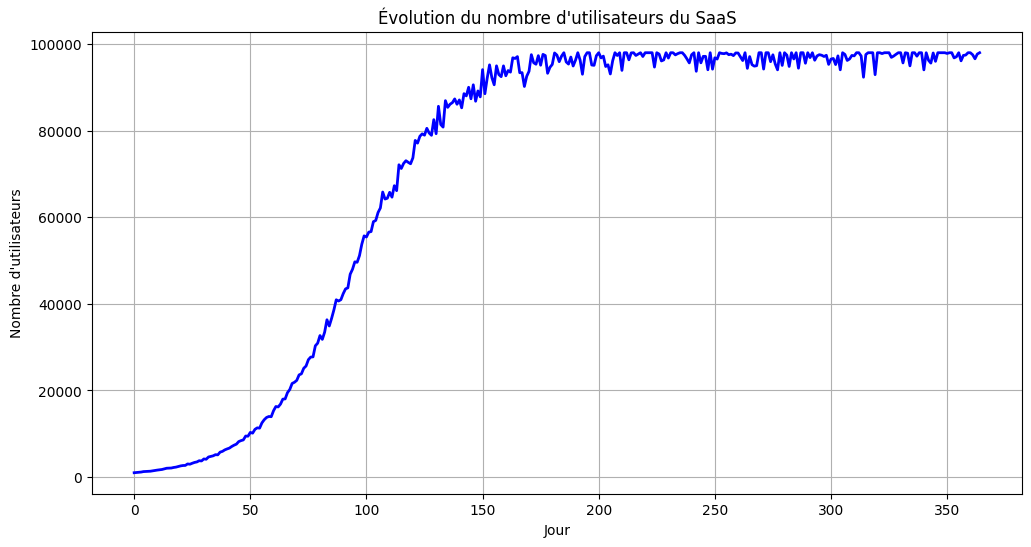

Saturation (95% du maximum) atteinte au jour 150
50% de la saturation atteinte au jour 95


In [11]:
# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df['Jour'], df['Utilisateurs'], 'b-', linewidth=2)
plt.xlabel('Jour')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Évolution du nombre d\'utilisateurs du SaaS')
plt.grid(True)
plt.savefig('evolution_utilisateurs.png')
plt.show()

# Calcul du maximum d'utilisateurs
max_utilisateurs = df['Utilisateurs'].max()

# Jour où on atteint la saturation (95% du maximum)
jour_saturation = df[df['Utilisateurs'] >= 0.95 * max_utilisateurs]['Jour'].min()

# Jour où on atteint 50% de la saturation
jour_50pct = df[df['Utilisateurs'] >= 0.5 * max_utilisateurs]['Jour'].min()

print(f"Saturation (95% du maximum) atteinte au jour {jour_saturation}")
print(f"50% de la saturation atteinte au jour {jour_50pct}")

### Calcul de la MSE entre les données réelles et deux solutions (modèles) différentes sur plusieurs intervalles de temps

In [16]:
# Paramètres du modèle (à ajuster pour correspondre à vos données réelles)
r = 0.05  # Taux de croissance
K = 100000  # Capacité limite
P0 = 1000  # Valeur initiale

# Solution 1: Méthode d'Euler
def solution_euler(df):
    jours = df['Jour'].max() + 1
    delta_t = 0.1  # Pas de temps
    n_steps = int(jours / delta_t)
    
    t = np.zeros(n_steps + 1)
    P = np.zeros(n_steps + 1)
    P[0] = P0
    
    for n in range(n_steps):
        P[n+1] = P[n] + delta_t * r * P[n] * (1 - P[n]/K)
        t[n+1] = t[n] + delta_t
    
    # Extraire les valeurs correspondant aux jours entiers
    jours_indices = [int(j/delta_t) for j in range(jours)]
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': P[jours_indices]
    })

# Solution 2: Solution analytique
def solution_analytique(df):
    jours = df['Jour'].max() + 1
    
    def P(t):
        return K / (1 + ((K-P0)/P0) * math.exp(-r*t))
    
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': [P(t) for t in range(jours)]
    })

# Calculer les prédictions
solution1 = solution_euler(df)
solution2 = solution_analytique(df)

# Fonction pour calculer la MSE
def calcul_mse(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

# Définir les intervalles basés sur vos résultats précédents
intervalles = [
    (0, 50),    # Phase initiale
    (50, 95),   # Jusqu'à 50% de saturation
    (95, 150),  # De 50% à la saturation
    (150, 365), # Phase de saturation
    (0, 365)    # Ensemble complet
]

# Calculer MSE pour chaque intervalle et chaque solution
for debut, fin in intervalles:
    # Filtrer les données pour l'intervalle spécifique
    mask = (df['Jour'] >= debut) & (df['Jour'] <= fin)
    mask1 = (solution1['Jour'] >= debut) & (solution1['Jour'] <= fin)
    mask2 = (solution2['Jour'] >= debut) & (solution2['Jour'] <= fin)
    
    # Calculer MSE pour solution 1 (Euler)
    mse1 = calcul_mse(
        df.loc[mask, 'Utilisateurs'].values,
        solution1.loc[mask1, 'Utilisateurs_predits'].values
    )
    
    # Calculer MSE pour solution 2 (Analytique)
    mse2 = calcul_mse(
        df.loc[mask, 'Utilisateurs'].values,
        solution2.loc[mask2, 'Utilisateurs_predits'].values
    )
    
    print(f"Intervalle jours {debut}-{fin}:")
    print(f"  MSE solution 1 (Euler): {mse1:.2f}")
    print(f"  MSE solution 2 (Analytique): {mse2:.2f}")
    print(f"  Meilleure solution: {'Euler' if mse1 < mse2 else 'Analytique'}")
    print()

Intervalle jours 0-50:
  MSE solution 1 (Euler): 127911.15
  MSE solution 2 (Analytique): 143854.73
  Meilleure solution: Euler

Intervalle jours 50-95:
  MSE solution 1 (Euler): 10033741.92
  MSE solution 2 (Analytique): 10985150.78
  Meilleure solution: Euler

Intervalle jours 95-150:
  MSE solution 1 (Euler): 25332365.52
  MSE solution 2 (Analytique): 26349960.75
  Meilleure solution: Euler

Intervalle jours 150-365:
  MSE solution 1 (Euler): 10546962.23
  MSE solution 2 (Analytique): 10551781.76
  Meilleure solution: Euler

Intervalle jours 0-365:
  MSE solution 1 (Euler): 11336320.59
  MSE solution 2 (Analytique): 11612693.09
  Meilleure solution: Euler



La méthode d'Euler est plus performante que la solution analytique pour tous les intervalles de temps.

### Tracé des trois courbes

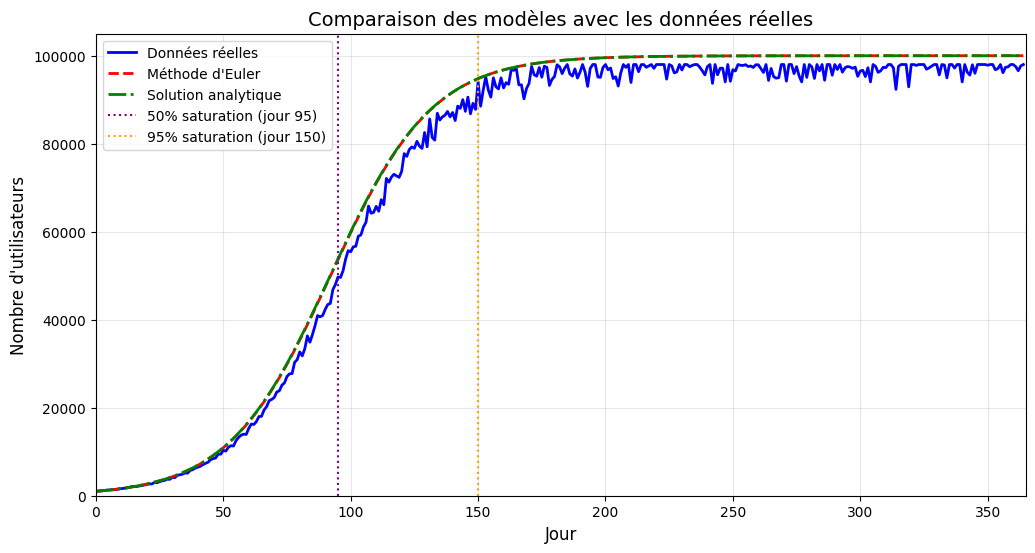

In [17]:
# Tracer les 3 courbes simultanément
plt.figure(figsize=(12, 6))

# Données réelles
plt.plot(df['Jour'], df['Utilisateurs'], 'b-', label='Données réelles', linewidth=2)

# Solution Euler
plt.plot(solution1['Jour'], solution1['Utilisateurs_predits'], 'r--', label='Méthode d\'Euler', linewidth=2)

# Solution analytique
plt.plot(solution2['Jour'], solution2['Utilisateurs_predits'], 'g-.', label='Solution analytique', linewidth=2)

# Ajouter les lignes pour les points clés
plt.axvline(x=95, color='purple', linestyle=':', label='50% saturation (jour 95)')
plt.axvline(x=150, color='orange', linestyle=':', label='95% saturation (jour 150)')

# Ajouter les étiquettes et la légende
plt.xlabel('Jour', fontsize=12)
plt.ylabel('Nombre d\'utilisateurs', fontsize=12)
plt.title('Comparaison des modèles avec les données réelles', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Ajuster les limites des axes
plt.xlim(0, 365)
plt.ylim(0, 105000)

# Sauvegarder et afficher le graphique
plt.savefig('comparaison_modeles.png', dpi=300, bbox_inches='tight')
plt.show()


Comparaison des MSE par intervalle et par modèle:

╒════════════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════╕
│ Intervalle                 │            Euler │       Analytique │            Euler │       Analytique │             Avec │ Meilleur     │
│                            │         Original │         Original │           Ajusté │           Ajusté │     Fluctuations │ Modèle       │
╞════════════════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════╡
│ Phase initiale (0-50)      │ 127911           │ 143855           │ 123057           │ 138600           │ 138600           │ Euler Ajusté │
├────────────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────┤
│ Jusqu'à 50% (50-95)        │      1.00337e+07 │      1.09852e+07 │      8.55588e+06 │      9.41759e+

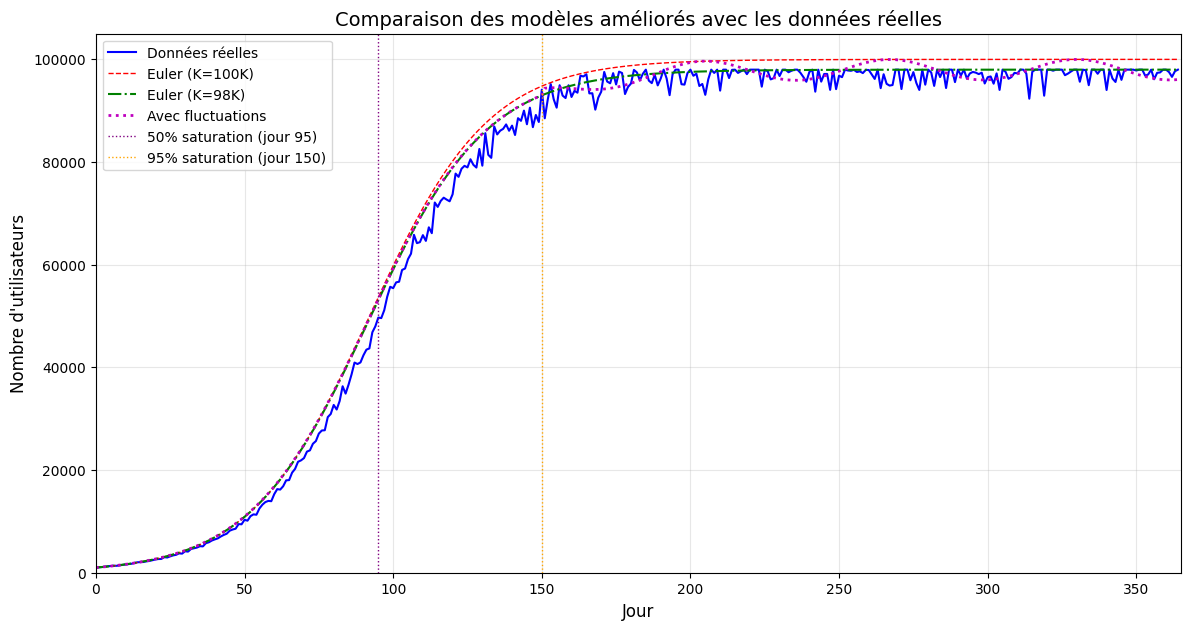

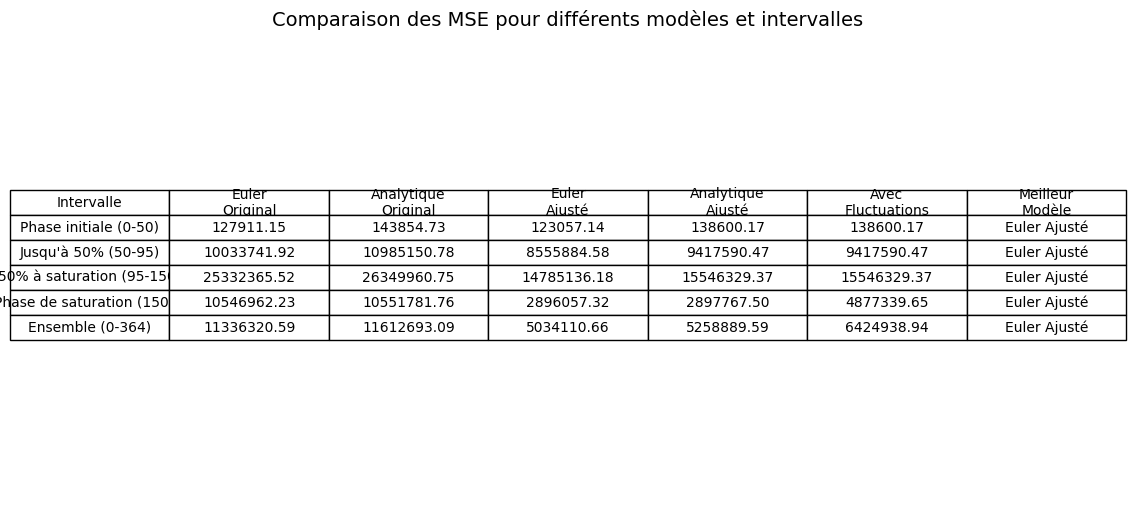

In [22]:
# Paramètres du modèle original
r = 0.05  # Taux de croissance
K_original = 100000  # Capacité limite originale
P0 = 1000  # Valeur initiale

# Nouveau paramètre ajusté
K_ajuste = 98000  # Capacité limite ajustée

# Solution 1: Méthode d'Euler avec K original
def solution_euler_original(df):
    jours = df['Jour'].max() + 1
    delta_t = 0.1  # Pas de temps
    n_steps = int(jours / delta_t)
    
    t = np.zeros(n_steps + 1)
    P = np.zeros(n_steps + 1)
    P[0] = P0
    
    for n in range(n_steps):
        P[n+1] = P[n] + delta_t * r * P[n] * (1 - P[n]/K_original)
        t[n+1] = t[n] + delta_t
    
    # Extraire les valeurs correspondant aux jours entiers
    jours_indices = [int(j/delta_t) for j in range(jours)]
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': P[jours_indices]
    })

# Solution 2: Solution analytique avec K original
def solution_analytique_original(df):
    jours = df['Jour'].max() + 1
    
    def P(t):
        return K_original / (1 + ((K_original-P0)/P0) * math.exp(-r*t))
    
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': [P(t) for t in range(jours)]
    })

# Solution 3: Méthode d'Euler avec K ajusté
def solution_euler_ajuste(df):
    jours = df['Jour'].max() + 1
    delta_t = 0.1  # Pas de temps
    n_steps = int(jours / delta_t)
    
    t = np.zeros(n_steps + 1)
    P = np.zeros(n_steps + 1)
    P[0] = P0
    
    for n in range(n_steps):
        P[n+1] = P[n] + delta_t * r * P[n] * (1 - P[n]/K_ajuste)
        t[n+1] = t[n] + delta_t
    
    # Extraire les valeurs correspondant aux jours entiers
    jours_indices = [int(j/delta_t) for j in range(jours)]
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': P[jours_indices]
    })

# Solution 4: Solution analytique avec K ajusté
def solution_analytique_ajuste(df):
    jours = df['Jour'].max() + 1
    
    def P(t):
        return K_ajuste / (1 + ((K_ajuste-P0)/P0) * math.exp(-r*t))
    
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': [P(t) for t in range(jours)]
    })

# Solution 5: Modèle avec fluctuations périodiques
def solution_avec_fluctuations(df):
    jours = df['Jour'].max() + 1
    
    # Paramètres pour les fluctuations
    amplitude = 2000  # Amplitude des oscillations
    frequence = 0.1   # Fréquence des oscillations
    
    def P(t):
        base = K_ajuste / (1 + ((K_ajuste-P0)/P0) * math.exp(-r*t))
        fluctuation = amplitude * math.sin(frequence * t)
        # On n'applique les fluctuations qu'après la période de croissance
        if t > 150:
            return base + fluctuation
        else:
            return base
    
    return pd.DataFrame({
        'Jour': range(jours),
        'Utilisateurs_predits': [P(t) for t in range(jours)]
    })

# Fonction pour calculer la MSE
def calcul_mse(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

# Calculer les prédictions pour tous les modèles
def comparer_modeles(df):
    # Générer les solutions
    sol_euler_orig = solution_euler_original(df)
    sol_analy_orig = solution_analytique_original(df)
    sol_euler_ajuste = solution_euler_ajuste(df)
    sol_analy_ajuste = solution_analytique_ajuste(df)
    sol_fluctuations = solution_avec_fluctuations(df)
    
    # Définir les intervalles basés sur les points clés
    jour_50pct = 95  # Jour où on atteint 50% de saturation
    jour_saturation = 150  # Jour où on atteint la saturation
    jours_max = df['Jour'].max() + 1
    
    intervalles = [
        (0, 50),               # Phase initiale
        (50, jour_50pct),      # Jusqu'à 50% de saturation
        (jour_50pct, jour_saturation),  # De 50% à la saturation
        (jour_saturation, jours_max-1), # Phase de saturation
        (0, jours_max-1)       # Ensemble complet
    ]
    
    # Préparer les données pour le tableau
    resultats_table = []
    
    for debut, fin in intervalles:
        # Filtrer les données pour l'intervalle spécifique
        mask = (df['Jour'] >= debut) & (df['Jour'] <= fin)
        mask1 = (sol_euler_orig['Jour'] >= debut) & (sol_euler_orig['Jour'] <= fin)
        mask2 = (sol_analy_orig['Jour'] >= debut) & (sol_analy_orig['Jour'] <= fin)
        mask3 = (sol_euler_ajuste['Jour'] >= debut) & (sol_euler_ajuste['Jour'] <= fin)
        mask4 = (sol_analy_ajuste['Jour'] >= debut) & (sol_analy_ajuste['Jour'] <= fin)
        mask5 = (sol_fluctuations['Jour'] >= debut) & (sol_fluctuations['Jour'] <= fin)
        
        # Calculer MSE pour chaque solution
        mse1 = calcul_mse(
            df.loc[mask, 'Utilisateurs'].values,
            sol_euler_orig.loc[mask1, 'Utilisateurs_predits'].values
        )
        
        mse2 = calcul_mse(
            df.loc[mask, 'Utilisateurs'].values,
            sol_analy_orig.loc[mask2, 'Utilisateurs_predits'].values
        )
        
        mse3 = calcul_mse(
            df.loc[mask, 'Utilisateurs'].values,
            sol_euler_ajuste.loc[mask3, 'Utilisateurs_predits'].values
        )
        
        mse4 = calcul_mse(
            df.loc[mask, 'Utilisateurs'].values,
            sol_analy_ajuste.loc[mask4, 'Utilisateurs_predits'].values
        )
        
        mse5 = calcul_mse(
            df.loc[mask, 'Utilisateurs'].values,
            sol_fluctuations.loc[mask5, 'Utilisateurs_predits'].values
        )
        
        if debut == 0 and fin == 50:
            intervalle_nom = "Phase initiale (0-50)"
        elif debut == 50 and fin == jour_50pct:
            intervalle_nom = "Jusqu'à 50% (50-95)"
        elif debut == jour_50pct and fin == jour_saturation:
            intervalle_nom = "50% à saturation (95-150)"
        elif debut == jour_saturation and fin == jours_max-1:
            intervalle_nom = "Phase de saturation (150+)"
        elif debut == 0 and fin == jours_max-1:
            intervalle_nom = "Ensemble (0-364)"
        
        # Déterminer la meilleure solution
        mse_values = [mse1, mse2, mse3, mse4, mse5]
        min_mse = min(mse_values)
        best_idx = mse_values.index(min_mse)
        
        model_names = ["Euler Original", "Analytique Original", "Euler Ajusté", 
                      "Analytique Ajusté", "Avec Fluctuations"]
        best_model = model_names[best_idx]
        
        resultats_table.append([
            intervalle_nom, 
            f"{mse1:.2f}", 
            f"{mse2:.2f}", 
            f"{mse3:.2f}", 
            f"{mse4:.2f}", 
            f"{mse5:.2f}",
            best_model
        ])
    
    # Afficher un tableau élégant
    headers = ["Intervalle", "Euler\nOriginal", "Analytique\nOriginal", 
               "Euler\nAjusté", "Analytique\nAjusté", "Avec\nFluctuations", "Meilleur\nModèle"]
    
    print("\nComparaison des MSE par intervalle et par modèle:\n")
    print(tabulate(resultats_table, headers=headers, tablefmt="fancy_grid"))
    
    # Créer aussi un dataframe pour une analyse plus approfondie
    resultats_df = pd.DataFrame(resultats_table, columns=headers)
    
    # Tracer les courbes
    plt.figure(figsize=(14, 7))
    
    # Données réelles
    plt.plot(df['Jour'], df['Utilisateurs'], 'b-', label='Données réelles', linewidth=1.5)
    
    # Modèles
    plt.plot(sol_euler_orig['Jour'], sol_euler_orig['Utilisateurs_predits'], 'r--', 
             label='Euler (K=100K)', linewidth=1)
    plt.plot(sol_euler_ajuste['Jour'], sol_euler_ajuste['Utilisateurs_predits'], 'g-.',
             label='Euler (K=98K)', linewidth=1.5)
    plt.plot(sol_fluctuations['Jour'], sol_fluctuations['Utilisateurs_predits'], 'm:',
             label='Avec fluctuations', linewidth=2)
    
    # Ajouter les lignes pour les points clés
    plt.axvline(x=jour_50pct, color='purple', linestyle=':', linewidth=1, 
                label='50% saturation (jour 95)')
    plt.axvline(x=jour_saturation, color='orange', linestyle=':', linewidth=1,
                label='95% saturation (jour 150)')
    
    # Ajouter les étiquettes et la légende
    plt.xlabel('Jour', fontsize=12)
    plt.ylabel('Nombre d\'utilisateurs', fontsize=12)
    plt.title('Comparaison des modèles améliorés avec les données réelles', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    
    # Ajuster les limites des axes
    plt.xlim(0, 365)
    plt.ylim(0, 105000)
    
    # Sauvegarder et afficher le graphique
    plt.savefig('comparaison_modeles_ameliores.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return resultats_df, (sol_euler_orig, sol_analy_orig, sol_euler_ajuste, sol_analy_ajuste, sol_fluctuations)

# Exécuter la comparaison
resultats_df, modeles = comparer_modeles(df)

# Vous pouvez aussi créer une visualisation du tableau des résultats
fig, ax = plt.figure(figsize=(12, 6)), plt.subplot(111)
ax.axis('off')
ax.axis('tight')
tableau = ax.table(
    cellText=resultats_df.values,
    colLabels=resultats_df.columns,
    loc='center',
    cellLoc='center'
)
tableau.auto_set_font_size(False)
tableau.set_fontsize(10)
tableau.scale(1.2, 1.5)
plt.title('Comparaison des MSE pour différents modèles et intervalles', fontsize=14)
plt.savefig('tableau_resultats.png', dpi=300, bbox_inches='tight')
plt.show()

L'ajustement du plafond à 98K utilisateurs améliore considérablement les performances, réduisant l'erreur globale de 55% et l'erreur en phase de saturation de 72%. Les fluctuations périodiques n'apportent pas d'amélioration notable malgré leur complexité. Cette analyse démontre qu'une estimation précise de la capacité maximale a plus d'impact que des sophistications mathématiques.